# Preamble

In [1]:
import pickle
import warnings
import numpy as np
import pandas as pd

import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt
from matplotlib.pyplot import Axes
from matplotlib.colors import ListedColormap

from typing import List, Dict, Union, Tuple, TypedDict, Any

warnings.filterwarnings('ignore')
#%cd /workspaces/bev2seg_2/
#%cd /home/VICOMTECH/agarciaj/GitLab/bev2seg_2
%cd /home/ag6154lk/BEV2Seg_2

DATA_PATH = "./data/pipeline_mask_evaluations.pkl"

# Window = 5 and turning_threshold = 5.0 deg
TRACK_TURN_FLAGS_5DEG = [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False]

/home/ag6154lk/BEV2Seg_2


## Functions

In [2]:
# This represents the structure for the numerical evaluation metrics for a single frame.
class EvaluationInfo(TypedDict):
    mean_precision_per_class: List[float]
    mean_accuracy_per_class: List[float]
    mean_f1score_per_class: List[float]
    mean_recall_per_class: List[float]
    mean_iou_per_class: List[float]
    conf_matrix: np.ndarray
MaskEvaluation = Dict[
    str, # The scene_name (e.g., 'scene_A')
    Dict[
        Union[int, str], # Keys can be integers (frame numbers) or strings ('labels', 'colors')
        Union[EvaluationInfo, List[str], List[Tuple[int, int, int]]] # Values can be EvaluationInfo, List[str] or List[Tuple[int, int, int]]
    ]
]


def show_evaluations(data:MaskEvaluation):
    evaluated_scenes = list(data.keys())
    results = []
    for scene_name in evaluated_scenes:
        scene = data[scene_name]
        assert 'labels' in scene
        assert 'colors' in scene
        
        frames = [fk for fk in scene.keys() if isinstance(fk, int)]
        num_labels = len(scene['labels'])
        num_frames = len(frames)

        for fk in frames:
            frame_data:EvaluationInfo = scene[fk]
        results.append( (scene_name, num_frames, num_labels) )


    results.sort(key=lambda x: x[0])
    res = tabulate(results, headers=['Scene name', 'Num frames', 'Num labels'])

    print(f"SAVED EVALUATIONS IN {DATA_PATH}:")
    print(res)

def plot_bars(y_values:np.ndarray,
              x_values:np.ndarray=None, 
              labels:List[str]=None, 
              bar_label:str=None,
              title:str="", 
              xlabel:str = "xlabel", 
              ylabel:str = "ylabel", 
              colors:List[Tuple[int]]=None, 
              bar_width:float=0.8,
              set_xlim:bool=False,
              ylim:Tuple[float, float]=None,
              label_rotation:float=0.0,
              rotation_data:List[int]=None,
              none_color:str = "#FFFFFF",
              aligned_color:str  = "#00A697",
              not_aligned_color:str   = "#C00071",
              ax:Axes=None) -> Axes:
    if ax is None:
        ax = plt.gca()
    if x_values is not None:
        assert y_values.shape == x_values.shape
    if colors is None:
        colors = 'skyblue'

    # RGB 0-255 -> 0-1    
    if len(colors) == 1:
        colors = np.array(colors[0]) / 255
    else:
        new_colors = []
        for c in colors:
            new_colors.append(np.array(c) / 255)
        colors = new_colors
    
    if x_values is None:
        x_values = np.array(list(range(len(y_values))))
    
    ax.bar(x_values, y_values, color=colors, align='center', width=bar_width, label=bar_label)
    if ylim is not None:
        ax.set_ylim(ylim)
    if labels is not None:
        ax.set_xticks(x_values, labels, rotation=label_rotation)

    if set_xlim:
        x_min_plot = x_values[0] - bar_width/2
        x_max_plot = x_values[-1] + bar_width/2
        ax.set_xlim(x_min_plot, x_max_plot)
    

    if rotation_data is not None:
        cmap_turning = ListedColormap([none_color, aligned_color, not_aligned_color])
        rotation_values = np.array(rotation_data).astype(int).reshape(1, -1)
        
        # Create a small inset axis below the main axis
        # [x, y, width, height] - coordinates relative to parent axis (0 to 1)
        inset_ax = ax.inset_axes([0, -0.05, 1, 0.025], transform=ax.transAxes)
        # Use the same precise x_min_plot and x_max_plot for imshow extent
        inset_ax.imshow(rotation_values, aspect='auto',
                        extent=[x_min_plot, x_max_plot, 0, 1],
                        cmap=cmap_turning,
                        vmin=0, vmax=2) 
        # Remove ticks and spines from the inset axis
        inset_ax.set_xticks([])
        inset_ax.set_yticks([])
        inset_ax.spines['top'].set_visible(False)
        inset_ax.spines['right'].set_visible(False)
        inset_ax.spines['left'].set_visible(False)
        inset_ax.spines['bottom'].set_visible(False)
        
        # Ajusta el layout de las etiquetas del eje principal para evitar solapamiento
        ax.tick_params(axis='x', which='major', pad=10)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return ax


def show_mean_iou_per_class_through_all_frames(
        data:MaskEvaluation, 
        eval_name:str, 
        show_conf_matrix:bool = True, 
        conf_figure_title:str = "", 
        show_iou_figure:bool = True, 
        iou_figure_title:str = ""):
    assert eval_name in data
    assert 'labels'  in data[eval_name]
    assert 'colors'  in data[eval_name]

    frame_keys = list( data[eval_name].keys() )
    frame_keys.pop(frame_keys.index('labels'))
    frame_keys.pop(frame_keys.index('colors'))
    labels = data[eval_name]['labels']
    colors = data[eval_name]['colors']

    assert len(frame_keys) > 0
    first_conf_matrix = data[eval_name][frame_keys[0]]['conf_matrix']
    accum_conf_matrix = np.zeros(first_conf_matrix.shape)

    # Accum Conf Matrix
    for fk in frame_keys: 
        assert 'conf_matrix' in data[eval_name][fk], f"frame {fk} does not have 'conf_matrix'" 
        accum_conf_matrix += data[eval_name][fk]['conf_matrix']


    # Show Conf Matrix
    if show_conf_matrix:
        sns.heatmap(accum_conf_matrix, annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(conf_figure_title)
        plt.show()

    # mIoU
    num_classes = accum_conf_matrix.shape[0]
    iou_per_class = np.zeros(num_classes)
    for c in range(num_classes):
        tp = accum_conf_matrix[c, c]
        fp = np.sum(accum_conf_matrix[c, :]) - tp
        fn = np.sum(accum_conf_matrix[:, c]) - tp

        denominator = tp + fp + fn
        if denominator == 0:
            iou_per_class[c] = np.nan
        else:
            iou_per_class[c] = tp / denominator

    print(f"Mean IoU per class along all frames: {iou_per_class}")
    valid_ious = np.array( [ v for v in iou_per_class if not np.isnan(v)] )
    print(f"Mean IoU along all frames: {np.mean(valid_ious)} std: {np.std(valid_ious)}")

    if show_iou_figure:
        plot_bars(iou_per_class, 
                  labels=labels, 
                  colors=colors, 
                  title=iou_figure_title, 
                  xlabel="Class", ylabel="IoU", ylim=(0.0, 1.0))
        plt.tight_layout()
        plt.show()


def plot_mean_iou_per_frame(
        data:MaskEvaluation, 
        eval_name:str, 
        semantic_class:str, 
        title:str=None,
        rotation_data:List[int]=None,
        ax:Axes=None) -> Axes:
    assert eval_name in data
    assert 'labels'  in data[eval_name]
    assert 'colors'  in data[eval_name]
    
    if ax is None:
        ax = plt.gca()

    frame_keys = list( data[eval_name].keys() )
    frame_keys.pop(frame_keys.index('labels'))
    frame_keys.pop(frame_keys.index('colors'))
    labels = data[eval_name]['labels']
    colors = data[eval_name]['colors']
    
    assert len(frame_keys) > 0
    assert semantic_class in labels
    semantic_index = labels.index(semantic_class)

    iou_per_frame = np.zeros(len(frame_keys))

    for fk in frame_keys:
        assert semantic_index < len( data[eval_name][fk]['mean_iou_per_class'] ) 
        iou = data[eval_name][fk]['mean_iou_per_class'][semantic_index]
        iou_per_frame[fk] = iou

    # print(f"IoU per frame for '{semantic_class}' class: {iou_per_frame}")
    iou_per_frame = np.array( [v if not np.isnan(v) else 0.0 for v in iou_per_frame] )
    title = title if title is not None else f"IoU evolution of {semantic_class}"
    
    plot_bars(iou_per_frame, 
              colors=[colors[semantic_index]], 
              title=title, 
              bar_label=semantic_class,
              xlabel="Frame", ylabel="IoU", 
              ylim=(0.0, 1.0), set_xlim=True, 
              rotation_data=rotation_data,
              ax=ax)
    return ax

def plot_mean_iou_frames_comparison(data:MaskEvaluation, 
                                    eval_name:str, 
                                    semantic_classes:List[str]=['occluded', 'occuped', 'driveable'],
                                    use_rotation_data:List[bool]=None,
                                    rotation_flags:List[bool]=TRACK_TURN_FLAGS_5DEG
                                    ):
    assert eval_name in data \
        and 'labels' in data[eval_name] \
        and 'colors' in data[eval_name]
    if use_rotation_data is not None:
        assert len(use_rotation_data) == len(semantic_classes)

    frame_keys = list(data[eval_name].keys())
    frame_keys.pop(frame_keys.index('labels'))
    frame_keys.pop(frame_keys.index('colors'))
    num_frames = len(frame_keys)
    assert num_frames > 0
    assert num_frames == len(TRACK_TURN_FLAGS_5DEG)

    fig, axes = plt.subplots(1, len(semantic_classes), figsize=(len(semantic_classes) * 4, 4), sharex=False, sharey=False) 
    handles, legend_labels = [], []
    for i, c in enumerate(semantic_classes):
        rotation_data = None
        if use_rotation_data is not None:
            rotation_data = [1 if not v else 2 for v in rotation_flags] if use_rotation_data[i] else [0 for _ in range(num_frames)]
        plot_mean_iou_per_frame(data, eval_name, c, title="", rotation_data=rotation_data, ax=axes[i])
        h, ll = axes[i].get_legend_handles_labels()
        handles += h
        legend_labels += ll

    fig.legend(handles, legend_labels,loc='lower center',ncol=len(legend_labels),bbox_to_anchor=(0.5, -0.05),frameon=False)

    plt.tight_layout()
    plt.show()



# Data Import

In [3]:
data = None
with open(DATA_PATH, "rb") as f:
    data = pickle.load(f)
show_evaluations(data)

SAVED EVALUATIONS IN ./data/pipeline_mask_evaluations.pkl:
Scene name      Num frames    Num labels
------------  ------------  ------------
scene-0061              38             4


# Nosedemomento

In [4]:
data['scene-0061']

{0: {'mean_precision_per_class': array([0.85107676, 0.62340066, 0.97883897, 0.96515797]),
  'mean_recall_per_class': array([0.99399204, 0.72637205, 0.65884568, 0.78858892]),
  'mean_accuracy_per_class': array([0.90328693, 0.97826099, 0.95985603, 0.92346573]),
  'mean_f1score_per_class': array([0.91699944, 0.67095862, 0.78757998, 0.86798487]),
  'mean_iou_per_class': array([0.84672111, 0.50484404, 0.64959335, 0.76676083]),
  'conf_matrix': array([[5.60200e+05, 8.17000e+02, 0.00000e+00, 2.56900e+03],
         [8.76000e+02, 2.32410e+04, 1.67800e+03, 6.20100e+03],
         [2.73780e+04, 1.22750e+04, 7.80350e+04, 7.54000e+02],
         [6.97710e+04, 9.48000e+02, 9.00000e+00, 2.63824e+05]])},
 1: {'mean_precision_per_class': array([0.88661853, 0.84667641, 0.98999934, 0.96860847]),
  'mean_recall_per_class': array([0.98179941, 0.89034835, 0.96316944, 0.80941532]),
  'mean_accuracy_per_class': array([0.92563248, 0.99327374, 0.99374771, 0.92984676]),
  'mean_f1score_per_class': array([0.9317846

Mean IoU per class along all frames: [0.80200819 0.16620268 0.60650998 0.57182432]
Mean IoU along all frames: 0.536636292210573 std: 0.23117300488425885


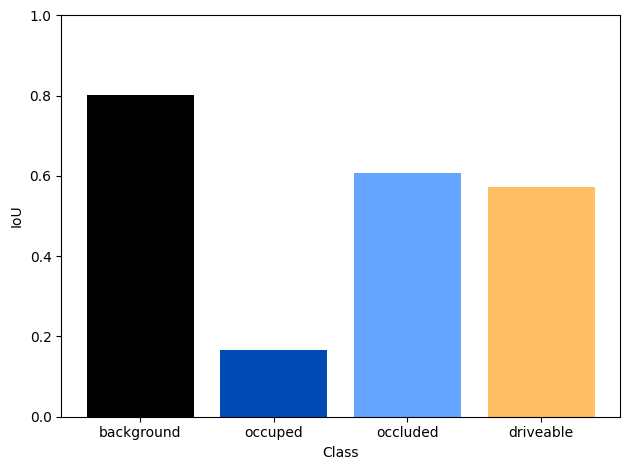

In [5]:
show_mean_iou_per_class_through_all_frames(data, 'scene-0061', show_conf_matrix=False, show_iou_figure=True)

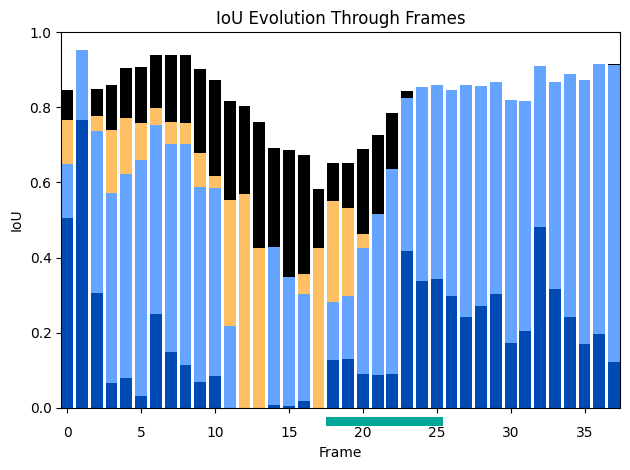

In [6]:
plot_mean_iou_per_frame(data, 'scene-0061', 'background', title="")
plot_mean_iou_per_frame(data, 'scene-0061', 'driveable', title="", rotation_data=TRACK_TURN_FLAGS_5DEG)
plot_mean_iou_per_frame(data, 'scene-0061', 'occluded', title="")
plot_mean_iou_per_frame(data, 'scene-0061', 'occuped', title="IoU Evolution Through Frames")
plt.tight_layout()
plt.show()

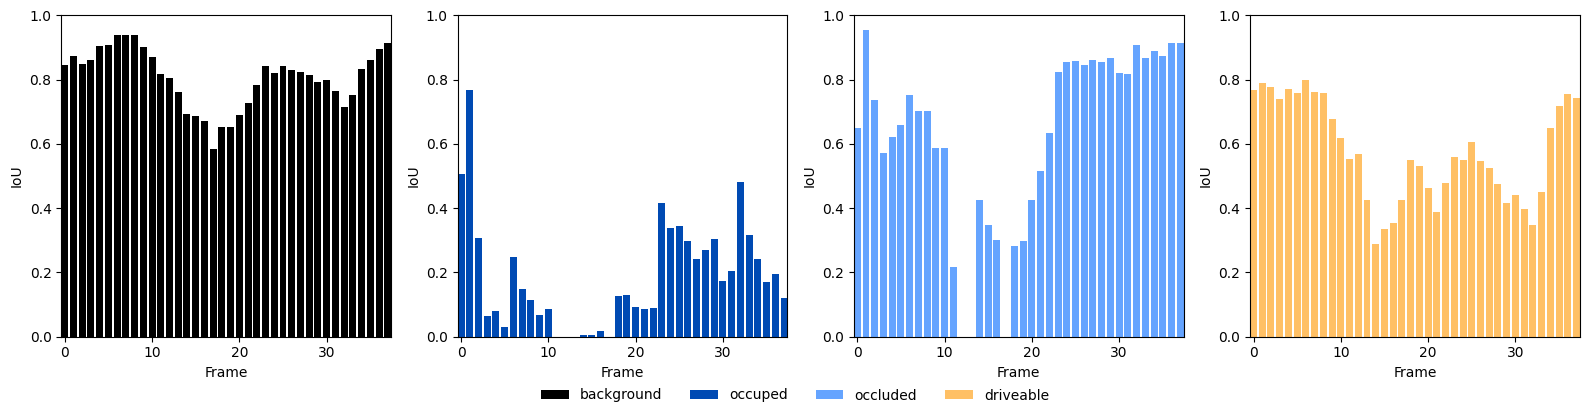

In [9]:
AUX = [False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
plot_mean_iou_frames_comparison(data, 
                                eval_name='scene-0061', 
                                semantic_classes=['background', 'occuped', 'occluded', 'driveable'], 
                                #use_rotation_data=[False, False, False, True],
                                use_rotation_data=None,
                                rotation_flags=AUX
                                )

<Axes: xlabel='Frame', ylabel='IoU'>

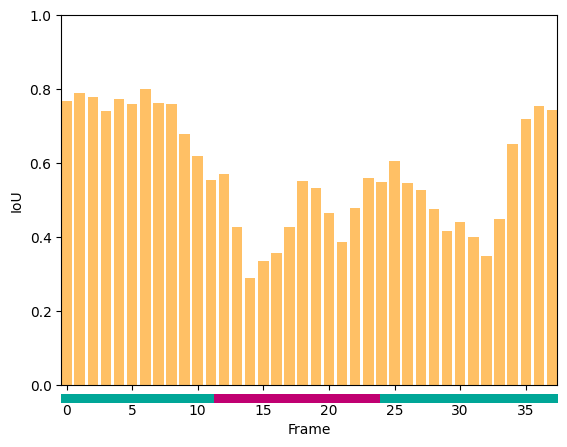

In [8]:
rotation_data = [1 if not v else 2 for v in AUX]
plot_mean_iou_per_frame(data, 'scene-0061', 'driveable', title="", rotation_data=rotation_data)
